# Импортируем библиотеки

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import warnings

from time import gmtime

# Мелкие настройки

In [67]:
%matplotlib inline
plt.style.use(['fivethirtyeight'])
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

# Глобальные переменные

In [68]:
SOURCE_TRAIN_CSV = 'data/train.csv'
SOURCE_TEST_CSV = 'data/test.csv'
filename = 'PutilinVladislav_pred.csv'

# Дополнительные функции

In [69]:
# Функция позаимствована
def ir(name):
    a = df_train.loc[df_train[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

# Функция позаимствована
def irt(name):
    a = df_test.loc[df_test[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

In [103]:
# Графики
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Загружаем данные

In [70]:
df_train = pd.read_csv(SOURCE_TRAIN_CSV)
df_test = pd.read_csv(SOURCE_TEST_CSV)

# Анализируем данные

In [71]:
# Посмотрим какие есть столбцы
print("Наименование столбцов:")
for column in df_train.columns:
    print("\t" + column)

Наименование столбцов:
	Id
	DistrictId
	Rooms
	Square
	LifeSquare
	KitchenSquare
	Floor
	HouseFloor
	HouseYear
	Ecology_1
	Ecology_2
	Ecology_3
	Social_1
	Social_2
	Social_3
	Healthcare_1
	Helthcare_2
	Shops_1
	Shops_2
	Price


In [72]:
# Смотрим описание столбцов
print("Смотрим описание столбцов\n")
df_train.info()

Смотрим описание столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [73]:
# Смотрим базоыве статистические данные
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


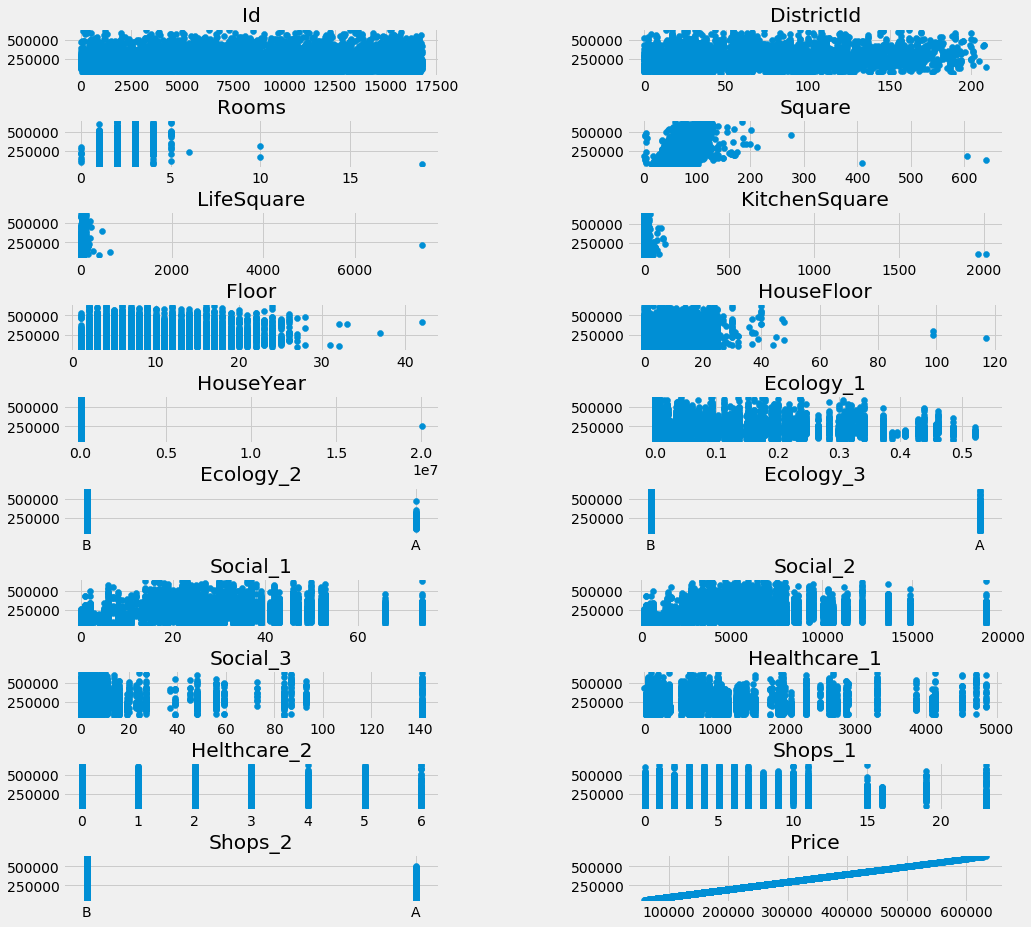

In [74]:
# Смотрим разброс в данных
cols = df_train.columns
nrows = math.ceil(len(cols) / 2)

fig, ax = plt.subplots(nrows=nrows, ncols=2)
ax = ax.flatten()
for i, j in enumerate(cols):
    ax[i].scatter(df_train[j], df_train['Price'])
    ax[i].set_title(j)
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.5, hspace=0.9)

# Чистим данные

In [75]:
# Удаляем дубликаты
df_train.drop_duplicates()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [76]:
# Смотрим датасет на null значения
df_train.isnull().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare        True
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Ecology_2        False
Ecology_3        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1      True
Helthcare_2      False
Shops_1          False
Shops_2          False
Price            False
dtype: bool

In [77]:
# Принудительно назначаем тип данных, т.к. количество комнат не может быть дробным, так же как и количество этажей в доме и т.д.

df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)
df_train['HouseYear'] = df_train['HouseYear'].astype(int)

In [78]:
# Для чистки даты года постройки HouseYear, берем минимальный и теукущий год (максимальный)
x_min_year = ir('HouseYear')[0]
x_max_year = gmtime().tm_year

In [79]:
# Правим год строительст
year_median = int(df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median())
df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median
df_train['HouseYear'].describe()

count    10000.000000
mean      1984.639100
std         17.743994
min       1934.000000
25%       1974.000000
50%       1977.000000
75%       1999.250000
max       2018.000000
Name: HouseYear, dtype: float64

In [80]:
# Правим этажи в домах
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = random.randint(1,df_train['HouseFloor'].median())
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor'] = random.randint(1, df_train['HouseFloor'].median())
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}] = df_train['HouseFloor'].apply(lambda x: random.randint(1, x))
print("Смотрим остались ли еще этажи за пределами дома:")
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}]

Смотрим остались ли еще этажи за пределами дома:


,Floor


In [81]:
# Правим комнаты
filter_rooms = df_train.loc[~((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]
filter_rooms = filter_rooms.groupby(['DistrictId','HouseYear']).median()

In [82]:
error_rooms = df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]
all_rooms = pd.merge(error_rooms, filter_rooms, on=['DistrictId','HouseYear'],how='left')

In [83]:
# Заменяем ошибочные данные по медианные
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6), 'Rooms'] = all_rooms['Rooms_y'].median()
# Остались ли еще ошибочные данные
df_train[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [84]:
# Чистим показатели местности, связанные с охраной здоровья (Healthcare_1)
# Healthcare_1
x_min_h1 = ir('Healthcare_1')[0]
x_max_h1 = ir('Healthcare_1')[1]
h1_median = df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1), 'Healthcare_1'].median()
# Если есть пустые значения, назначаем медианное значение
df_train.loc[df_train['Healthcare_1'].isnull() == True, 'Healthcare_1'] = h1_median
# Так же назначаем медианное значение если значение превышает максимальное и минимальное
df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1), 'Healthcare_1'] = h1_median

In [85]:
# Займемся площадью (Square)
first_quartile = df_train['Square'].quantile(.25) 
third_quartile = df_train['Square'].quantile(.75)

sdiff = third_quartile - first_quartile
smax = third_quartile + 1.5 * sdiff
smin = first_quartile - 1.5 * sdiff

df_train.loc[df_train['Square'] > smax, 'Square'] = df_train[df_train['Square']> smax].median()['Square']
df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'Square'] = df_train[df_train['LifeSquare'] > df_train['Square']]['LifeSquare']

In [86]:
# Для очистки данных по критерию "площадь кухни" (KitchenSquare) вычисляем:
# минимальное значение, максимальное значение и медианное
x_min_ksquare = ir('KitchenSquare')[0]
x_max_ksquare = ir('KitchenSquare')[1]
x_med_ksquare = df_train['KitchenSquare'].median()

In [87]:
# Чистим значения которые превосходят максимальное значение
df_train.loc[df_train['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare
# Чистим минимальное и назначаем медианное значение
df_train.loc[df_train['KitchenSquare'] < x_med_ksquare, 'KitchenSquare'] = x_med_ksquare

In [88]:
# Проверим жил площадь
print("Количество пустых или отрицательные значений в жилой площади: ", len(df_train.loc[(df_train['LifeSquare'].isnull()) | (df_train['LifeSquare'] < 0), 'LifeSquare']))
print("Количество пустых или отрицательные значений в площади: ", len(df_train.loc[(df_train['Square'].isnull() | df_train['Square'] < 0), 'Square']))

Количество пустых или отрицательные значений в жилой площади:  2113
Количество пустых или отрицательные значений в площади:  0


In [89]:
# Для нормализации жилой площади, вычитаем из общей площади кухню
df_train.loc[(df_train['LifeSquare'].isnull()) | (df_train['LifeSquare'] < 0), 'LifeSquare'] = df_train['Square'] - df_train['KitchenSquare']

In [90]:
# Нормализуем экологию и магазины
df_train['E_2'] = df_train['Ecology_2'].replace({'A':2, 'B':1})
df_train['E_3'] = df_train['Ecology_3'].replace({'A':2, 'B':1})
df_train['S_2'] = df_train['Shops_2'].replace({'A':2, 'B':1})

In [91]:
p25 = df_train['Price'].quantile(.25)
p75 = df_train['Price'].quantile(.75)

pdiff = p75 - p25
pmax = p75 + 1.5 * pdiff
pmin = p25 - 1.5 * pdiff

df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
df_train[(df_train['Square'] < smin)] = df_train['Square'].median()

In [92]:
# Расчитываем медианную цену за квадрат
df_train['Square_round'] = (round(df_train['Square'].astype(int)/10)*10).astype(int)

In [93]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

In [94]:
# Введем еще один категориальный признак размер района
district_size = df_train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_train = df_train.merge(district_size, on='DistrictId', how='left')

df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > df_train['DistrictSize'].median()).astype(int)

In [95]:
# Объеденяем в датасет
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [96]:
feature_names = ['Id','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'E_2', 'E_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'S_2', 'Square_round']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [97]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


In [98]:
X = df_train[feature_names + new_feature_names]
y = df_train[target_name]

In [99]:
# Остались пустые значеия или нет
df_train.isnull().any()

Id                    False
DistrictId            False
Rooms                 False
Square                False
LifeSquare            False
KitchenSquare         False
Floor                 False
HouseFloor            False
HouseYear             False
Ecology_1             False
Ecology_2             False
Ecology_3             False
Social_1              False
Social_2              False
Social_3              False
Healthcare_1          False
Helthcare_2           False
Shops_1               False
Shops_2               False
Price                 False
E_2                   False
E_3                   False
S_2                   False
Square_round          False
DistrictSize          False
IsDistrictLarge       False
MedPriceByDistrict    False
dtype: bool

In [100]:
# Описание датасета
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,8375.509007,50.424607,1.930007,57.153397,40.711346,7.570807,7.729407,13.358107,1983.095907,0.160889,...,1.360807,4.270807,213908.662157,1.051007,1.068807,1.123807,56.707000,241.68160,0.495900,211286.640748
std,4863.291130,43.578429,1.648480,76.999794,77.351447,2.607164,4.875817,5.740968,57.434791,1.489583,...,2.081821,4.996143,92944.337386,1.462922,1.468267,1.483314,77.144678,268.35081,0.500008,76759.063909
min,0.000000,0.000000,1.000000,5.610772,0.370619,6.000000,1.000000,1.000000,52.633651,0.000000,...,0.000000,0.000000,52.633651,1.000000,1.000000,1.000000,0.000000,1.00000,0.000000,52.633651
25%,4158.750000,20.000000,1.000000,41.883697,25.378658,6.000000,4.000000,10.000000,1974.000000,0.017647,...,0.000000,1.000000,153820.176034,1.000000,1.000000,1.000000,40.000000,55.00000,0.000000,165071.825722
50%,8389.500000,36.000000,2.000000,52.638875,35.587317,6.000000,7.000000,12.000000,1977.000000,0.075424,...,1.000000,3.000000,192152.769521,1.000000,1.000000,1.000000,50.000000,104.00000,0.000000,195474.299127
75%,12590.250000,75.000000,2.000000,66.004634,48.785321,9.000000,10.000000,17.000000,1999.000000,0.195781,...,2.000000,6.000000,249080.956886,1.000000,1.000000,1.000000,70.000000,510.00000,1.000000,241068.903045
max,16798.000000,209.000000,52.633651,7480.592129,7480.592129,52.633651,52.633651,117.000000,2018.000000,52.633651,...,52.633651,52.633651,633233.466570,52.633651,52.633651,52.633651,7480.000000,849.00000,1.000000,624156.003381


In [101]:
df_train.loc[(df_train['LifeSquare'] < 9),'LifeSquare'] = (df_train['Square'].median() - df_train['KitchenSquare'].median())

## Обучение

Train R2:	0.953
Test R2:	0.752


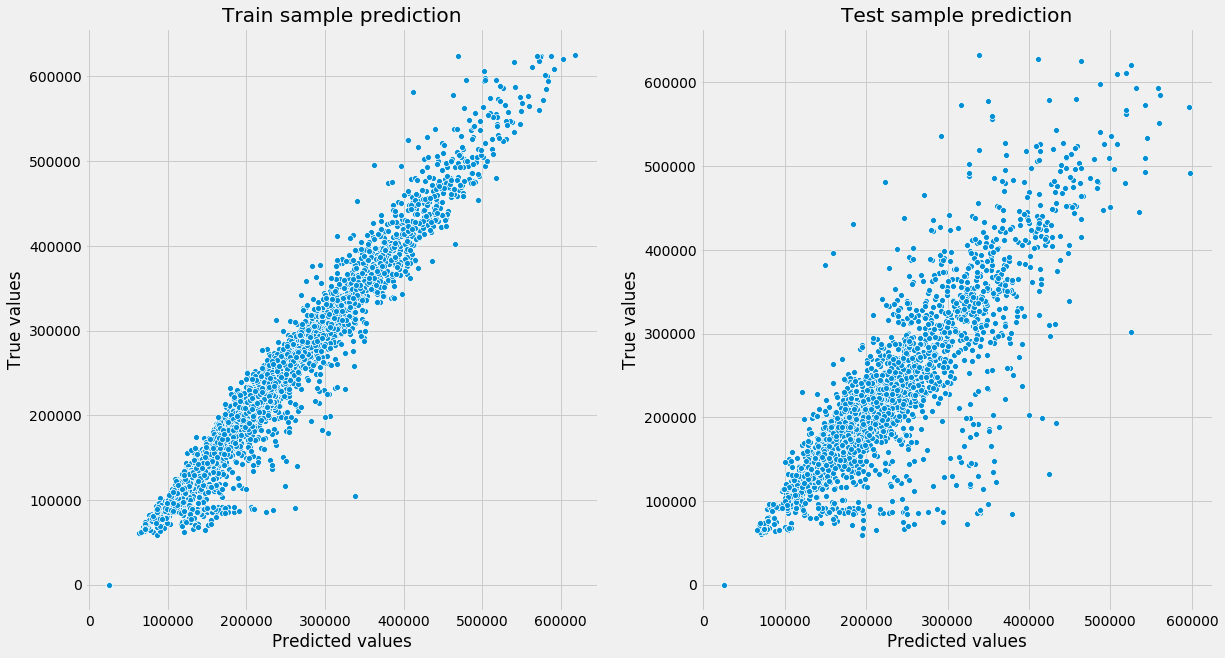

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, oob_score = True, max_depth = 17, n_estimators = 21)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [105]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=21))
cv_score.mean()

0.7468822096823717

In [106]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
20,MedPriceByDistrict,0.620274
2,Square,0.112272
3,LifeSquare,0.029347
13,Social_3,0.028149
4,KitchenSquare,0.025078
7,HouseYear,0.024957
6,HouseFloor,0.023176
0,Id,0.022401
5,Floor,0.020407
12,Social_2,0.019809


In [107]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


## Прогнозирование на тестовом датасете

In [108]:
df_test.head().sort_values(by = 'Id', ascending = True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


In [109]:
df_test['Rooms'] = df_test['Rooms'].astype(int)

df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)

x_min_yeart = irt('HouseYear')[0]

x_max_yeart = gmtime().tm_year

In [110]:
year_mediant = df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_max_yeart and x >= x_min_yeart),'HouseYear'].median()

In [111]:
df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_min_yeart or x >= x_max_yeart),'HouseYear'] = year_mediant

In [112]:
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

In [113]:
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = random.randint(1,df_test['HouseFloor'].median())

In [114]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor'] = df_test['HouseFloor'].median()

In [115]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], {'Floor'}] = df_test['HouseFloor'].apply(lambda x: random.randint(1, x))

In [116]:
filter1t = df_test.loc[~((df_test['Rooms'] == 0) | (df_test['Rooms'] > 6)),{'DistrictId','HouseYear','Rooms'}]

filter1t = filter1t.groupby(['DistrictId','HouseYear']).median()

In [117]:
df_test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

In [118]:
a = df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]

b = pd.merge(a, filter1t, on=['DistrictId','HouseYear'],how='left')

In [119]:
df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6), 'Rooms'] = b['Rooms_y'].median()

In [120]:
x_min_ksquaret = irt('KitchenSquare')[0]

x_max_ksquaret = irt('KitchenSquare')[1]

x_med_ksquaret = df_test['KitchenSquare'].median()

In [121]:
df_test.loc[df_test['KitchenSquare'] > x_max_ksquaret, 'KitchenSquare'] = x_max_ksquaret

In [122]:
df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquaret

In [123]:
x_min_h1t = irt('Healthcare_1')[0]

x_max_h1t = irt('Healthcare_1')[1]

h1_mediant = df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_max_h1t and x >= x_min_h1t),'Healthcare_1'].median()

In [124]:
df_test.loc[df_test['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [125]:
df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_min_h1t or x >= x_max_h1t),'Healthcare_1'] = h1_mediant

In [126]:
med_dift = df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}].median()['Square']-\
df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}].median()['LifeSquare']

df_test.loc[df_test['LifeSquare'].isnull(),'LifeSquare'] = df_test['Square'] - med_dift

In [127]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square'] + df_test['KitchenSquare']),'LifeSquare'] =\
df_test['Square'] - df_test['KitchenSquare']

In [128]:
s25t = df_test['Square'].quantile(.25) 

s75t = df_test['Square'].quantile(.75)

sdifft = s75t - s25t

smaxt = s75t + 1.5*sdifft

smint = s25t - 1.5*sdifft

df_test.loc[df_test['Square']> smaxt, 'Square'] = df_test[df_test['Square']> smaxt].median()['Square']

In [133]:
df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'Square'] = df_test[df_test['LifeSquare'] > df_test['Square']]['LifeSquare']

In [134]:
df_test['E_2'] = df_test['Ecology_2'].replace({'A':2, 'B':1})

df_test['E_3'] = df_test['Ecology_3'].replace({'A':2, 'B':1})

df_test['S_2'] = df_test['Shops_2'].replace({'A':2, 'B':1})

In [135]:
df_test['Square_round'] = (round(df_test['Square'].astype(int)/10)*10).astype(int)

In [136]:
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0.0,1.0,142799.434052
1,0.0,2.0,176210.812334
2,0.0,3.0,300610.359425
3,1.0,1.0,146574.015522
4,1.0,2.0,202666.310126


In [139]:
m = med_price_by_district.groupby(['DistrictId','Rooms']).median()


df_test = df_test.merge(m, on = ['DistrictId','Rooms'], how='left')

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,87,810.0,5,5,B,1,1,1,20,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,2,50,118336.969705


In [140]:
df_test.loc[df_test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = df_test['MedPriceByDistrict'].median()

In [142]:
df_test = df_test.rename(columns={'Square_x':'Square'})

In [143]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,87,810.0,5,5,B,1,1,1,20,197049.231078
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,2,50,118336.969705


In [145]:
df_test = df_test.drop('Shops_2', axis=1)

KeyError: "['Shops_2'] not found in axis"

In [146]:
df_test = df_test.drop('Ecology_2', axis=1)
df_test = df_test.drop('Ecology_3', axis=1)

In [147]:
df_test.isnull().any()

Id                    False
DistrictId            False
Rooms                 False
Square                False
LifeSquare            False
KitchenSquare         False
Floor                 False
HouseFloor            False
HouseYear             False
Ecology_1             False
Social_1              False
Social_2              False
Social_3              False
Healthcare_1          False
Helthcare_2           False
Shops_1               False
E_2                   False
E_3                   False
S_2                   False
Square_round          False
MedPriceByDistrict    False
dtype: bool

In [148]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,1437,3,900.0,0,2,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,7538,87,810.0,5,5,1,1,1,20,197049.231078
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,1,1,2,50,118336.969705


In [149]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


In [150]:
a = rf_model.predict(df_test)

In [151]:
a = pd.DataFrame(a,columns=['Price'])
a.head()

,Price
0,122494.348558
1,224599.010432
2,184655.703655
3,212539.487684
4,68626.270178


In [153]:
result = pd.concat([df_test['Id'].astype(int) , a['Price']], axis=1, sort=False)

result.to_csv(filename, index=False, encoding='utf-8')